In [17]:
%matplotlib inline

import os
from skimage import data, io, filters
import scipy.ndimage as ndimage
from skimage import color, img_as_float

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [3]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    def width(self):
        return self.x2 - self.x1
    
    def height(self):
        return self.y2 - self.y1
    
    def x_extent(self):
        return self.x1 + self.width()

    def y_extent(self):
        return self.y1 + self.height()
    
    def extract(self, img):
        return img[(b.y1 - 1):b.y_extent(), (b.x1 - 1):b.x_extent(), :]

    
    def taxicab_diagonal(self):
        '''
        Return the taxicab distance from (x1,y1) to (x2,y2)
        '''
        return self.x2 - self.x1 + self.y2 - self.y1
    
    def overlaps(self, other):
        '''
        Return True iff self and other overlap.
        '''
        return not ((self.x1 > other.x2)
                    or (self.x2 < other.x1)
                    or (self.y1 > other.y2)
                    or (self.y2 < other.y1))
    
    def __eq__(self, other):
        return (self.x1 == other.x1
                and self.y1 == other.y1
                and self.x2 == other.x2
                and self.y2 == other.y2)

    
def slice_to_bbox(slices):
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)

        
def remove_overlaps(bboxes):
    '''
    Return a set of BBoxes which contain the given BBoxes.
    When two BBoxes overlap, replace both with the minimal BBox that contains both.
    '''
    # list upper left and lower right corners of the Bboxes
    corners = []

    # list upper left corners of the Bboxes
    ulcorners = []

    # dict mapping corners to Bboxes.
    bbox_map = {}

    for bbox in bboxes:
        ul = (bbox.x1, bbox.y1)
        lr = (bbox.x2, bbox.y2)
        bbox_map[ul] = bbox
        bbox_map[lr] = bbox
        ulcorners.append(ul)
        corners.append(ul)
        corners.append(lr)        

    # Use a KDTree so we can find corners that are nearby efficiently.
    tree = spatial.KDTree(corners)
    new_corners = []
    for corner in ulcorners:
        bbox = bbox_map[corner]
        # Find all points which are within a taxicab distance of corner
        indices = tree.query_ball_point(
            corner, bbox_map[corner].taxicab_diagonal(), p = 1)
        for near_corner in tree.data[indices]:
            near_bbox = bbox_map[tuple(near_corner)]
            if bbox != near_bbox and bbox.overlaps(near_bbox):
                # Expand both bboxes.
                # Since we mutate the bbox, all references to this bbox in
                # bbox_map are updated simultaneously.
                bbox.x1 = near_bbox.x1 = min(bbox.x1, near_bbox.x1)
                bbox.y1 = near_bbox.y1 = min(bbox.y1, near_bbox.y1) 
                bbox.x2 = near_bbox.x2 = max(bbox.x2, near_bbox.x2)
                bbox.y2 = near_bbox.y2 = max(bbox.y2, near_bbox.y2) 
    return set(bbox_map.values())

def remove_dups(bboxes):
    clean_set = []
    for bbox in bboxes:
        if bbox not in clean_set:
            clean_set.append(bbox)
    return clean_set

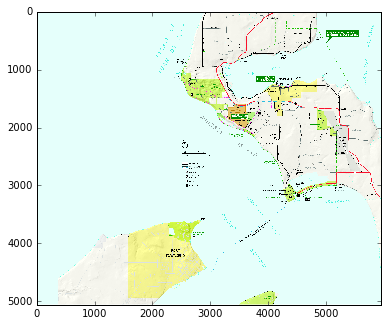

In [7]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5.5, 5.5, forward=True)

filename = '../out.jpg'
img = io.imread(filename, as_grey=False)

io.imshow(img)

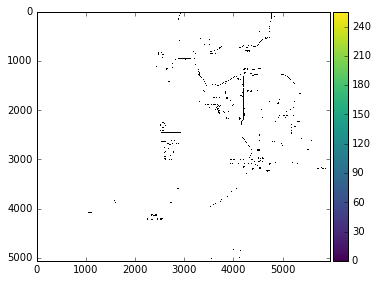

In [18]:
fimg = img_as_float(img)

filter_black = np.sum(fimg, axis=2)
fimg_bw = fimg.copy()
fimg_bw[(filter_black != 0)] = 1

io.imshow(img_bw)

In [20]:
fimg_bw_one = fimg_bw[:,:,1]
fimg_bw_one_invert = 1 - fimg_bw_one
labels, numobjects = ndimage.label(fimg_bw_one_invert)
slices = ndimage.find_objects(labels)

bboxes = (slice_to_bbox(slices))
#len(bboxes)
bboxes = remove_dups(bboxes)

In [21]:
bboxes_filter = [bbox for bbox in bboxes if (bbox.width() > 30) and (bbox.width() < 50) and (bbox.height() > 30) and (bbox.height() < 50)]
len(bboxes_filter)

36

In [23]:
icons = [b.extract(fimg_bw) for b in bboxes_filter]

icon_sums = [sum(np.sum(icon[:,:,1], axis=1)) for icon in icons]

In [41]:
icons_filter = [icon for ind, icon in enumerate(icons) if icon_sums[ind] < 1100.0]
len(icons_filter)

28

In [48]:
icons_filter = sorted(icons_filter, key=lambda x: sum(np.sum(x[:, :, 1], axis=1)))

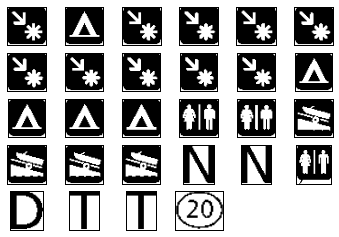

In [49]:
import math

fig = plt.figure()
width = 5
height = math.ceil(len(icons_filter) / float(width))
#width = len(icons_filter) / 2
i = 1
for icon in icons_filter:
    #ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(width,height,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(icon) 

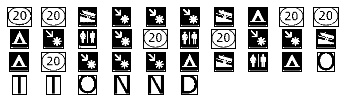

In [31]:
fig = plt.figure()
i = 1
for icon in icons_filter:
    #ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(10,10,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(icon) 